In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


DATA UNDERSTANDING AND PREPROCESSING

Operations:

    1. Checked data types, column names, and unique values.
    
    2. Verified there were no missing values in the dataset.

Basic Data Exploration

In [85]:
df = pd.read_csv(r"datasets\raw.csv")

# Additional data exploration beyond what was shown
# Check data types and verify no unexpected values
print(df['Neighborhood_Quality'].unique())
print(df.columns)

['Average' 'Excellent' 'Good' 'Poor']
Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built',
       'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price'],
      dtype='object')


In [86]:
# Create derived features that might be helpful
df['Age'] = 2025 - df['Year_Built']  # Current year minus year built
df['Price_Per_SqFt'] = df['House_Price'] / df['Square_Footage']

In [87]:
df.head(5)

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price,Age,Price_Per_SqFt
0,1360,2,1,1981,0.599637,0,Average,2.623829e+05,44,192.928568
1,4272,3,3,2016,4.753014,1,Average,9.852609e+05,9,230.632222
2,3592,1,2,2016,3.634823,0,Excellent,7.779774e+05,9,216.586133
3,966,1,2,1977,2.730667,1,Good,2.296989e+05,48,237.783560
4,4926,2,1,1993,4.699073,0,Good,1.041741e+06,32,211.478047


Data Cleaning Verification

In [88]:
def outliers(df, column):
    Q1 = np.percentile(df[column], 25) 
    Q3 = np.percentile(df[column], 75) 

    IQR=Q3-Q1

    LF= Q1-1.5*(IQR)
    UF= Q3+1.5*(IQR)

    outlier=df[(df[column]>UF) & (df[column]<LF)]
    return outlier 

for i in df.columns:
    if(df[i].dtypes in ("int64","float64")):
        print(f"Number of {i} outliers: {len(outliers(df,i))}")

Number of Square_Footage outliers: 0
Number of Num_Bedrooms outliers: 0
Number of Num_Bathrooms outliers: 0
Number of Year_Built outliers: 0
Number of Lot_Size outliers: 0
Number of Garage_Size outliers: 0
Number of House_Price outliers: 0
Number of Age outliers: 0
Number of Price_Per_SqFt outliers: 0


Conclusions:

    1.The dataset is clean, with no missing values.

    2.The Neighborhood_Quality column is categorical, while other columns are numerical.

    3.Derived features like Age (based on Year_Built) and Price_Per_SqFt (based on Square_Footage and House_Price) can provide additional insights.

UNIVARIATE ANALYSIS

Operations:

    1.Analyzed statistical summaries (mean, median, standard deviation, skewness, kurtosis).

    2.Plotted histograms for numerical features.



Numerical Features Distribution

In [89]:
# Statistical summary with additional metrics

numerical_features=['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms','Year_Built', 'Lot_Size', 'Garage_Size', 'House_Price']

for feature in numerical_features:
    print(f"\nSummary for {feature}:")
    summary = pd.DataFrame({
        'Mean': [np.mean(df[feature])],
        'Median': [np.median(df[feature])],
        'Std Dev': [np.std(df[feature])],
        'Skewness': [df[feature].skew()],
        'Kurtosis': [df[feature].kurt()],
        'Min': [np.min(df[feature])],
        'Max': [np.max(df[feature])]
    })
    print(summary)


Summary for Square_Footage:
       Mean  Median      Std Dev  Skewness  Kurtosis  Min   Max
0  2815.422  2862.5  1254.887006 -0.066001 -1.128061  503  4999

Summary for Num_Bedrooms:
   Mean  Median  Std Dev  Skewness  Kurtosis  Min  Max
0  2.99     3.0  1.42685  0.025884 -1.333604    1    5

Summary for Num_Bathrooms:
    Mean  Median   Std Dev  Skewness  Kurtosis  Min  Max
0  1.973     2.0  0.819921  0.049917 -1.512391    1    3

Summary for Year_Built:
      Mean  Median    Std Dev  Skewness  Kurtosis   Min   Max
0  1986.55  1986.0  20.622597 -0.021254 -1.185454  1950  2022

Summary for Lot_Size:
       Mean   Median   Std Dev  Skewness  Kurtosis       Min       Max
0  2.778087  2.80974  1.297254 -0.044288 -1.200895  0.506058  4.989303

Summary for Garage_Size:
    Mean  Median   Std Dev  Skewness  Kurtosis  Min  Max
0  1.022     1.0  0.814565   -0.0404 -1.493259    0    2

Summary for House_Price:
            Mean        Median        Std Dev  Skewness  Kurtosis  \
0  618861.01864

In [90]:
# Set up visualization style

sns.set_style('whitegrid')
sns.set_palette("Set2")

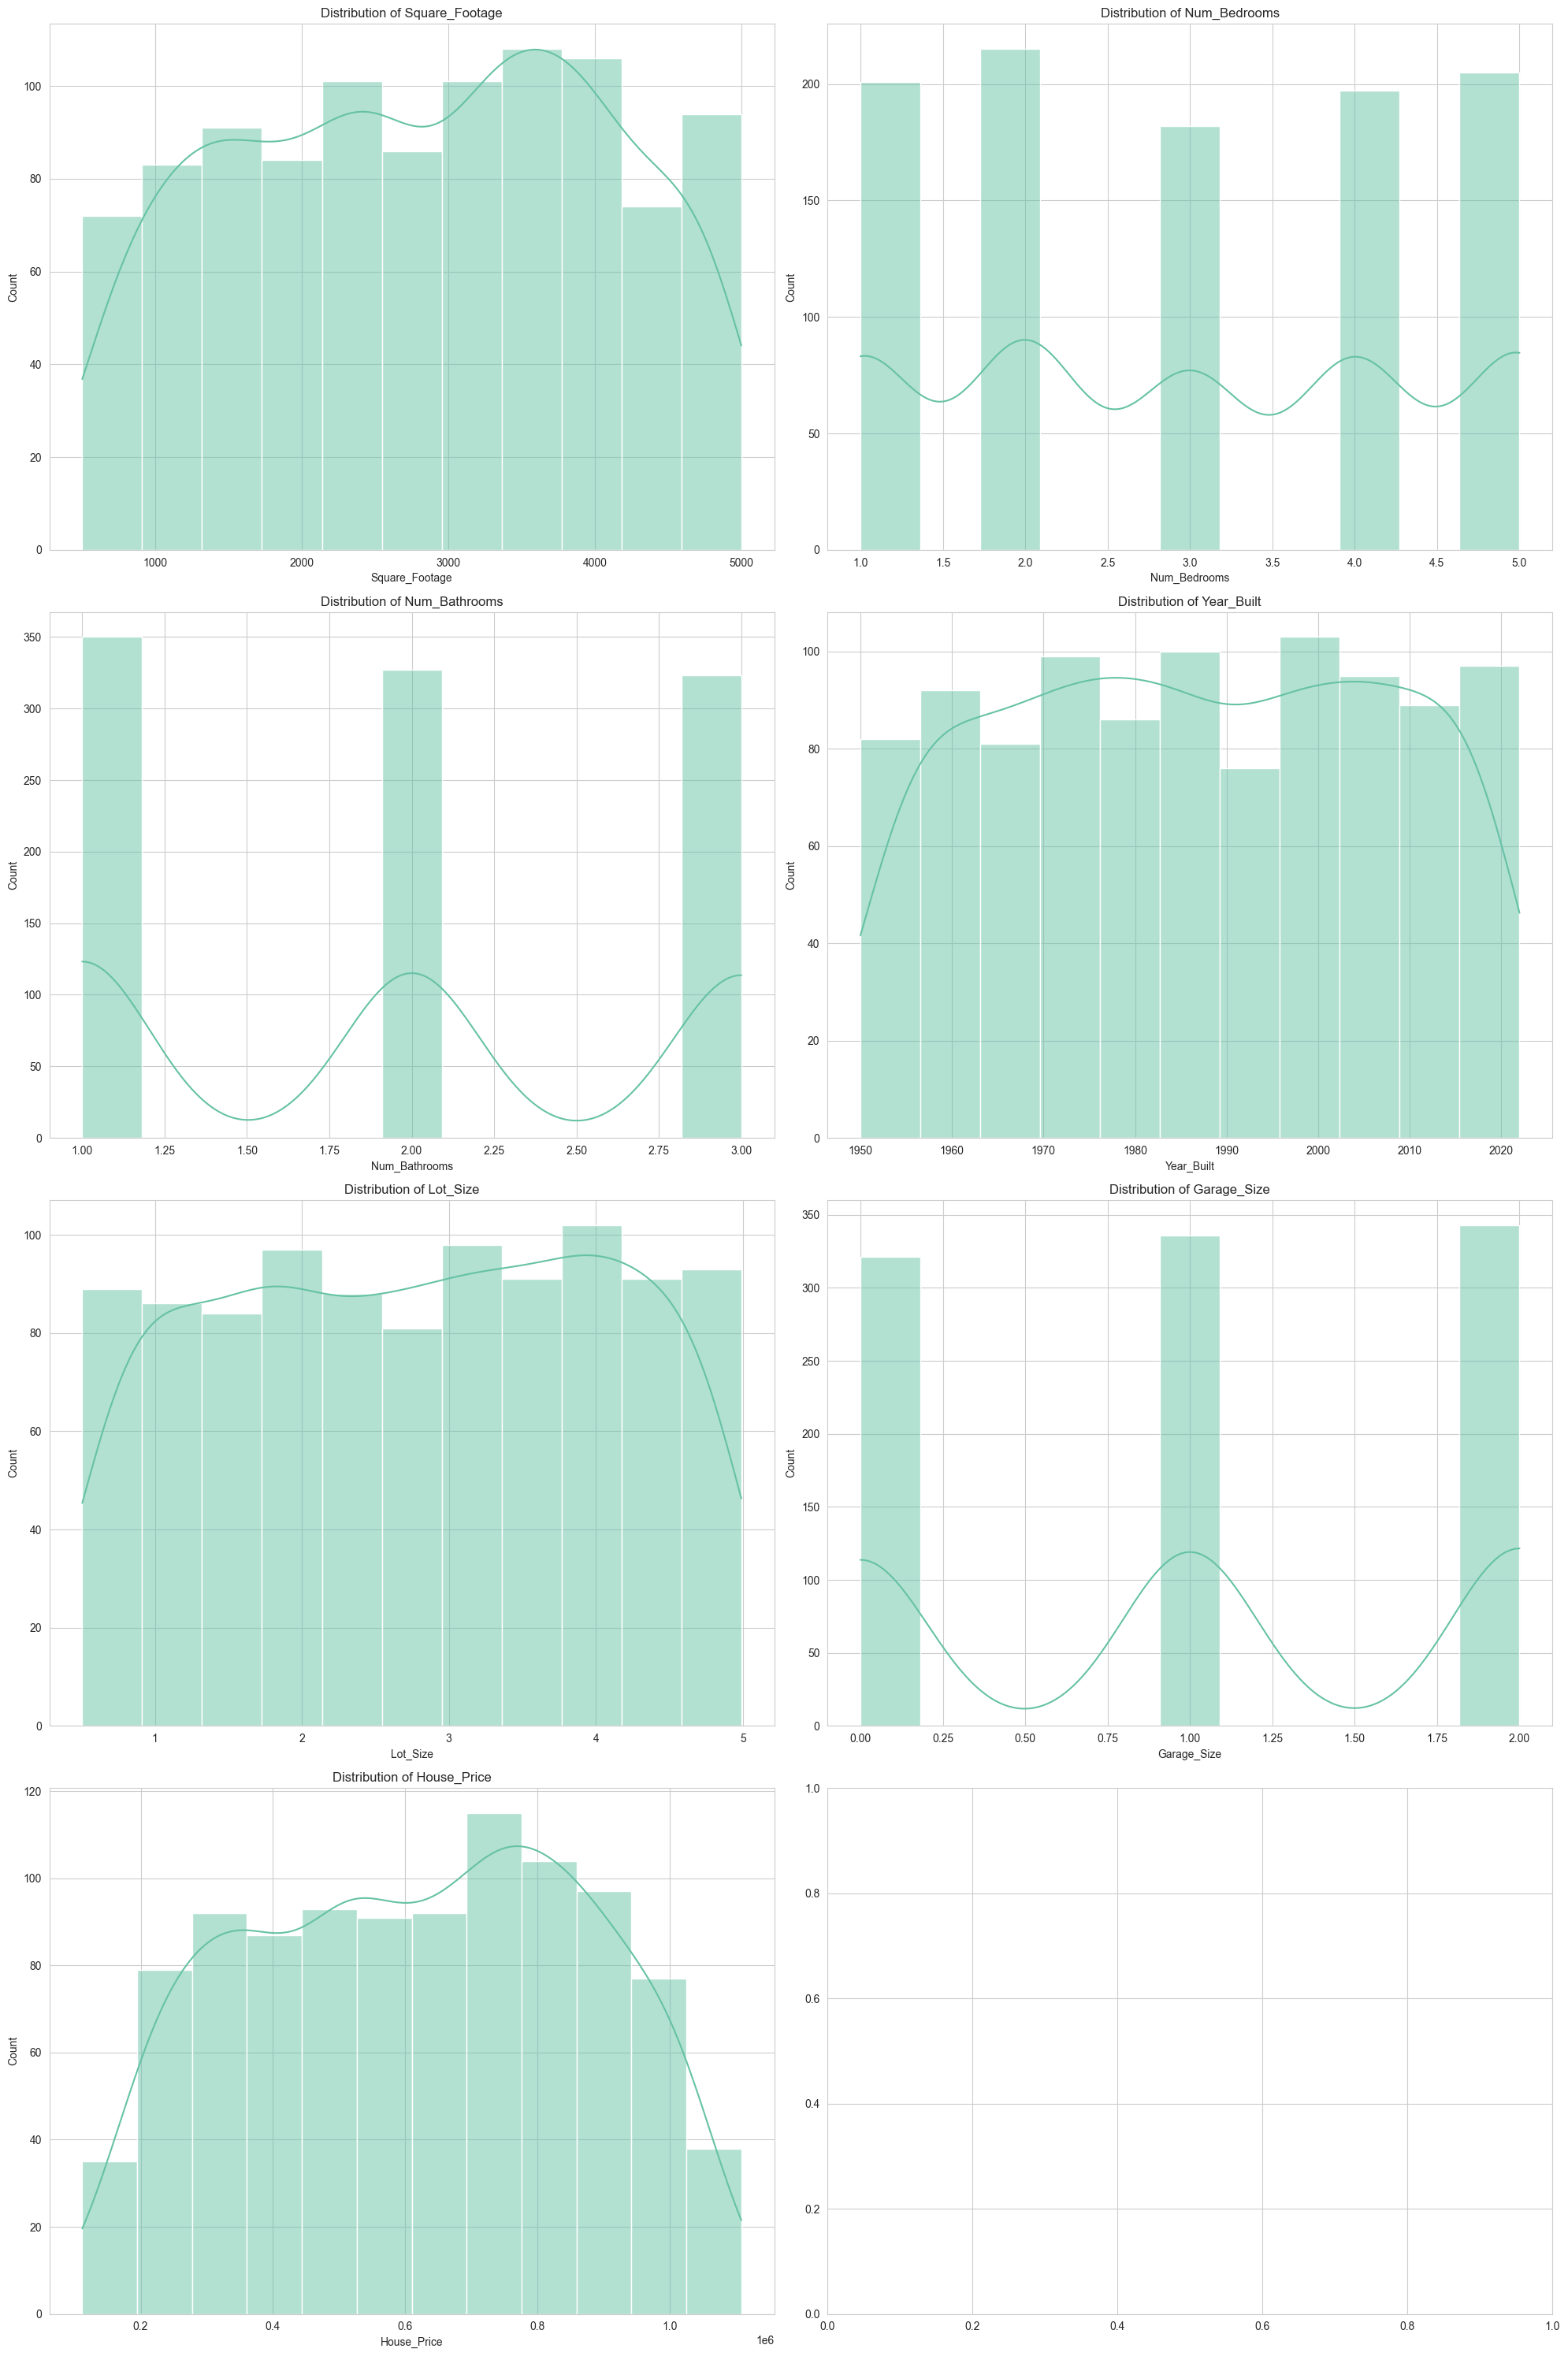

In [91]:
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        sns.histplot(df[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        
plt.tight_layout()
plt.show()

Conclusions:

    1.Square Footage: Right-skewed distribution; most houses are smaller in size, with a few very large properties.

    2.Number of Bedrooms/Bathrooms: Most houses have 2–4 bedrooms and 1–3 bathrooms.

    3.Year Built: Majority of houses were built after 1950, with a peak in recent decades.

    4.Lot Size: Highly skewed; most houses have small lots, but a few have very large ones.

    5.House Price: Right-skewed; most houses fall within a moderate price range, with some high-value outliers.

    6.Skewness in key features suggests potential need for transformations during modeling.

CATEGORICAL FEATURE ANALYSIS

Operations:

    1.Analyzed the distribution of Neighborhood_Quality.

    2.Examined average house prices for each neighborhood quality level using bar plots and box plots.

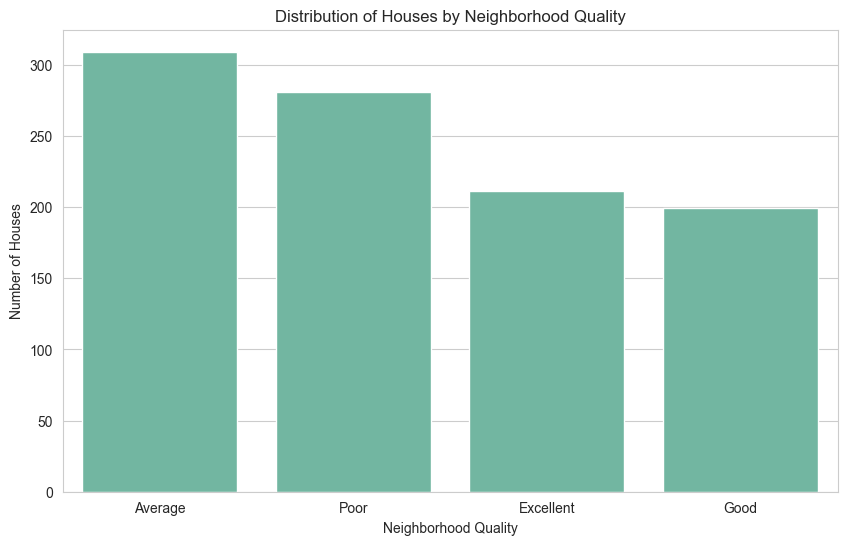

In [92]:
# Analyze neighborhood quality distribution
neighborhood_counts = df['Neighborhood_Quality'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=neighborhood_counts.index, y=neighborhood_counts.values)
plt.title('Distribution of Houses by Neighborhood Quality')
plt.ylabel('Number of Houses')
plt.xlabel('Neighborhood Quality')
plt.show()

In [93]:
# Average house price by neighborhood
neighborhood_price = df.groupby('Neighborhood_Quality')['House_Price'].agg(['mean', 'median', 'std', 'count'])
print(neighborhood_price)

                               mean       median            std  count
Neighborhood_Quality                                                  
Average               605864.586698  602549.2782  256963.085226    309
Excellent             611981.884961  644601.1052  249079.788441    211
Good                  640028.741444  654466.9454  251616.087737    199
Poor                  623327.274314  647832.2076  254770.209057    281


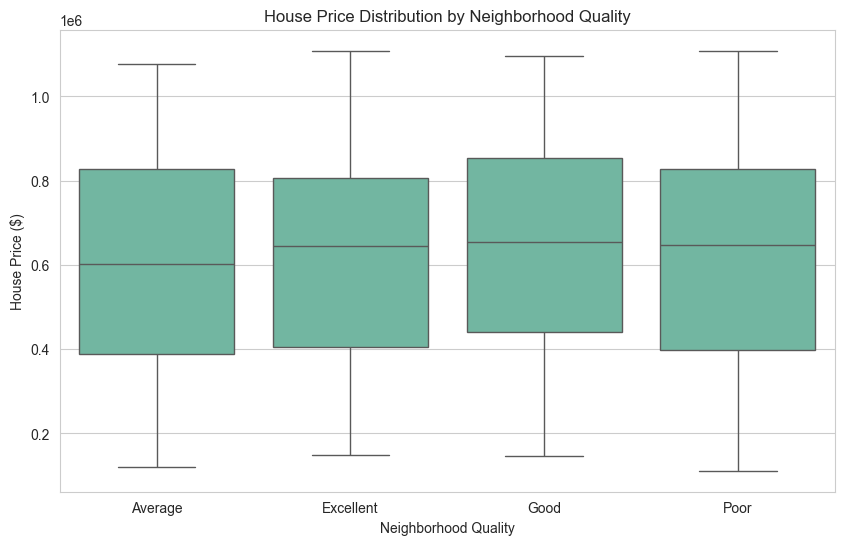

In [94]:
# Visualize price distribution by neighborhood
plt.figure(figsize=(10, 6))
sns.boxplot(x='Neighborhood_Quality', y='House_Price', data=df)
plt.title('House Price Distribution by Neighborhood Quality')
plt.ylabel('House Price ($)')
plt.xlabel('Neighborhood Quality')
plt.show()

Conclusions:

    1.Neighborhood quality is well-distributed across categories.

    2.Higher neighborhood quality correlates with higher average house prices.

    3.Significant price variability exists within each neighborhood quality level, indicating other factors also influence prices.

 BIVARIATE ANALYSIS

Operations:

    1.Correlation heatmap to assess relationships between numerical features.

    2.Scatter plots and regression lines for key variables against house price.

Correlation Analysis

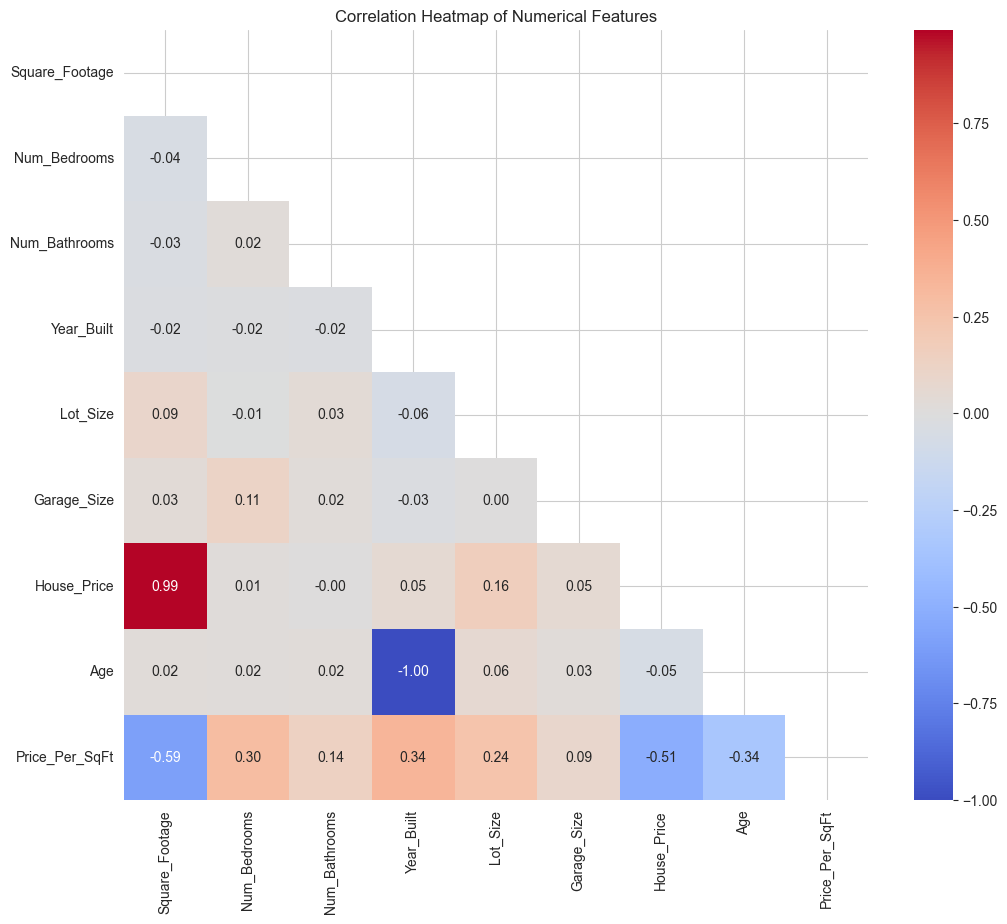

In [95]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [96]:
# Detailed price correlation analysis
price_correlations = correlation_matrix['House_Price'].sort_values(ascending=False)
print("Correlations with House Price:")
print(price_correlations)

Correlations with House Price:
House_Price       1.000000
Square_Footage    0.991261
Lot_Size          0.160412
Garage_Size       0.052133
Year_Built        0.051967
Num_Bedrooms      0.014633
Num_Bathrooms    -0.001862
Age              -0.051967
Price_Per_SqFt   -0.511148
Name: House_Price, dtype: float64


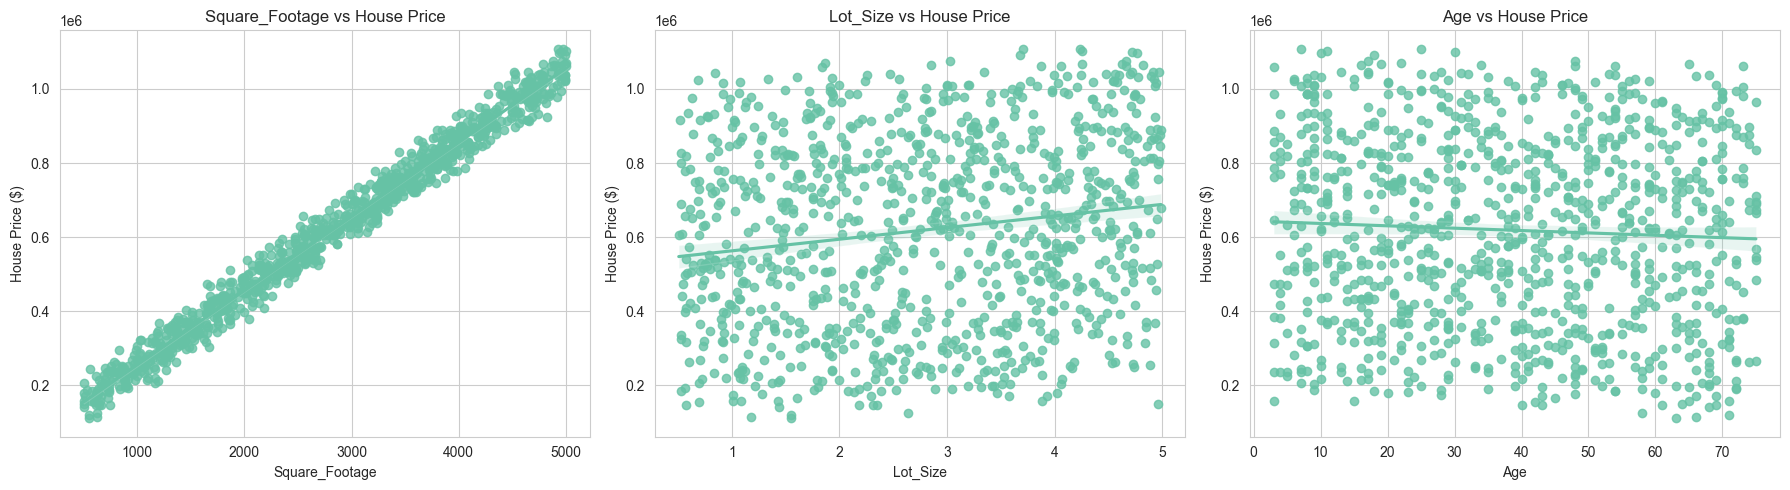

In [97]:
# Key scatter plots with regression lines
key_features = ['Square_Footage', 'Lot_Size', 'Age']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(key_features):
    sns.regplot(x=feature, y='House_Price', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} vs House Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('House Price ($)')
    
plt.tight_layout()
plt.show()

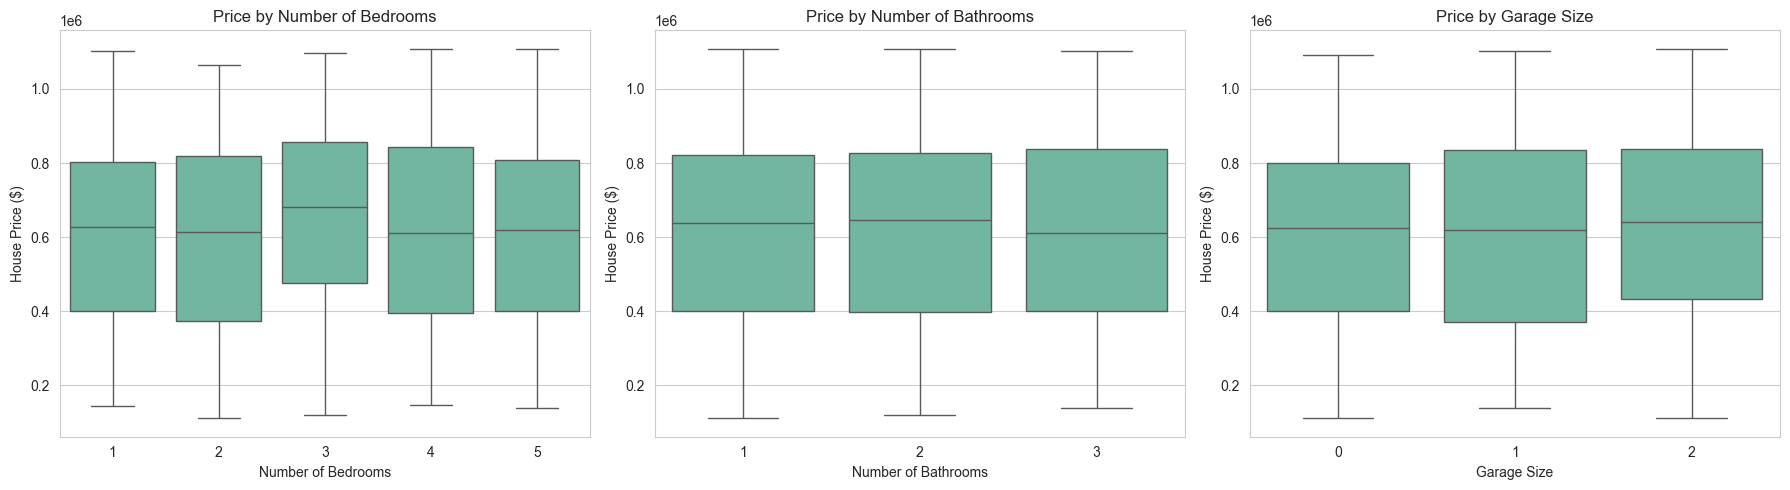

In [98]:
# Categorical feature relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Num_Bedrooms', y='House_Price', data=df, ax=axes[0])
axes[0].set_title('Price by Number of Bedrooms')
axes[0].set_xlabel('Number of Bedrooms')
axes[0].set_ylabel('House Price ($)')

sns.boxplot(x='Num_Bathrooms', y='House_Price', data=df, ax=axes[1])
axes[1].set_title('Price by Number of Bathrooms')
axes[1].set_xlabel('Number of Bathrooms')
axes[1].set_ylabel('House Price ($)')

sns.boxplot(x='Garage_Size', y='House_Price', data=df, ax=axes[2])
axes[2].set_title('Price by Garage Size')
axes[2].set_xlabel('Garage Size')
axes[2].set_ylabel('House Price ($)')

plt.tight_layout()
plt.show()


Conclusions:

    1.Square Footage has the strongest positive correlation with house price (r≈0.8).

    2.Lot Size, Number of Bathrooms, and Garage Size also show moderate positive correlations with house price.

    3.Weak or no correlation between Year Built and house price suggests that age alone is not a strong predictor of value.

    4.Outliers in features like Lot Size and House Price may influence correlations and require careful handling during modeling.

MUTLIVARIATE ANALYSIS

Operations:

    1.Pair plots to visualize relationships among multiple variables.

    2.Joint plots to analyze interactions between square footage, house price, and neighborhood quality.

Joint Plots and Pair Plots

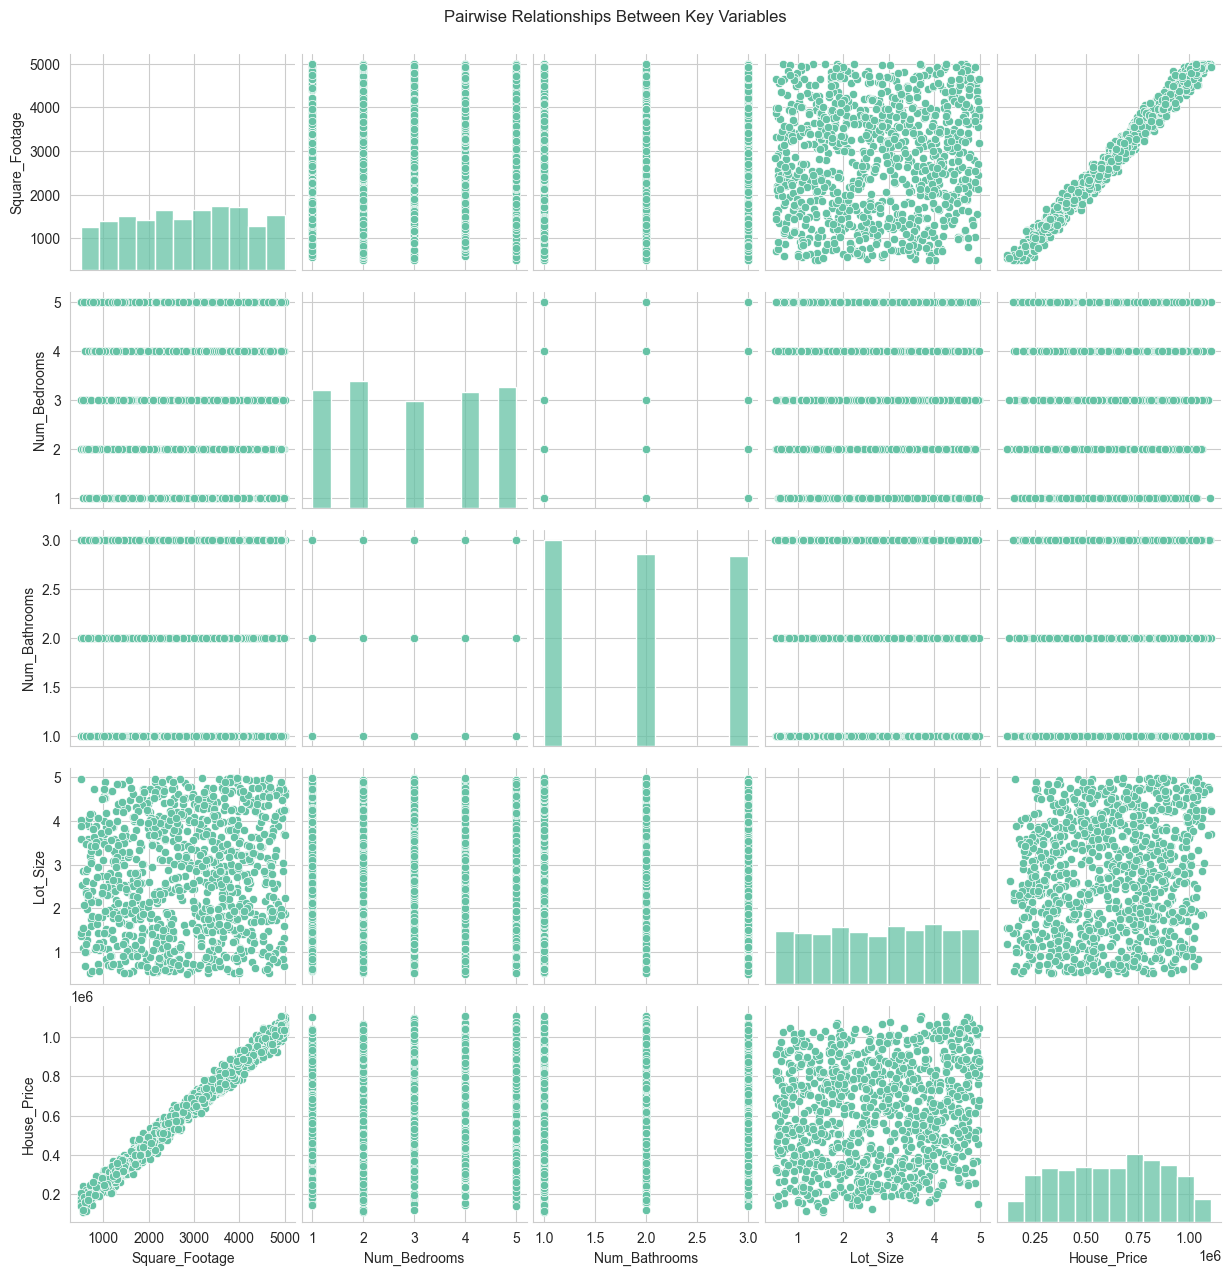

In [99]:
# Create a pair plot for key variables
key_vars = ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size', 'House_Price']
sns.pairplot(df[key_vars], height=2.5)
plt.suptitle('Pairwise Relationships Between Key Variables', y=1.02)
plt.show()

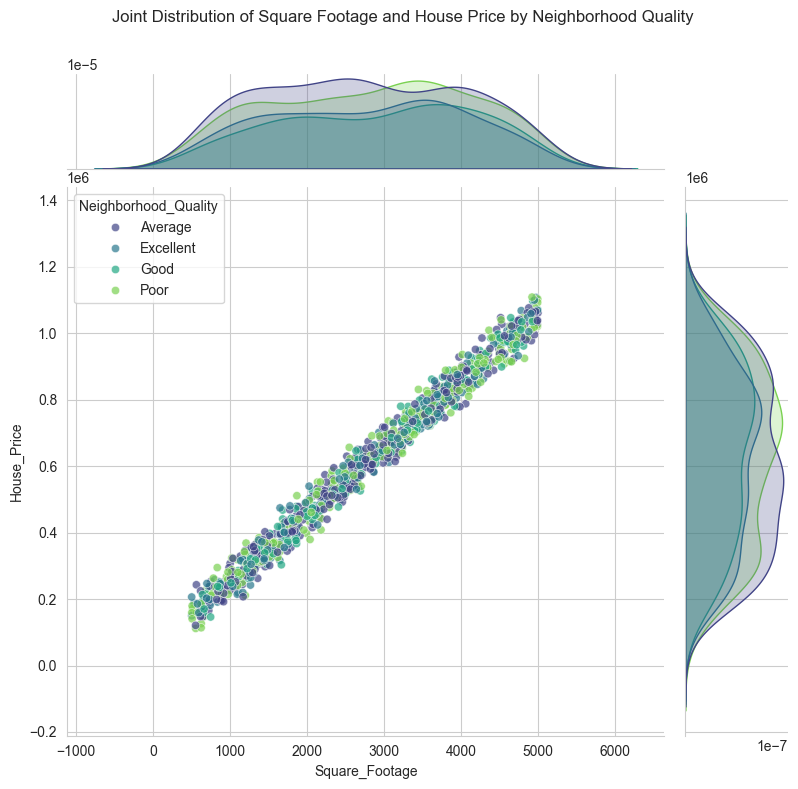

In [100]:

# Advanced joint plot with neighborhood quality
g = sns.JointGrid(data=df,x="Square_Footage",y="House_Price",hue="Neighborhood_Quality",height=8,palette="viridis"   )
g.plot_joint(sns.scatterplot, hue="Neighborhood_Quality", alpha=0.7)
g.plot_marginals(sns.kdeplot, fill=True)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Joint Distribution of Square Footage and House Price by Neighborhood Quality')
plt.show()

3D Visualizations

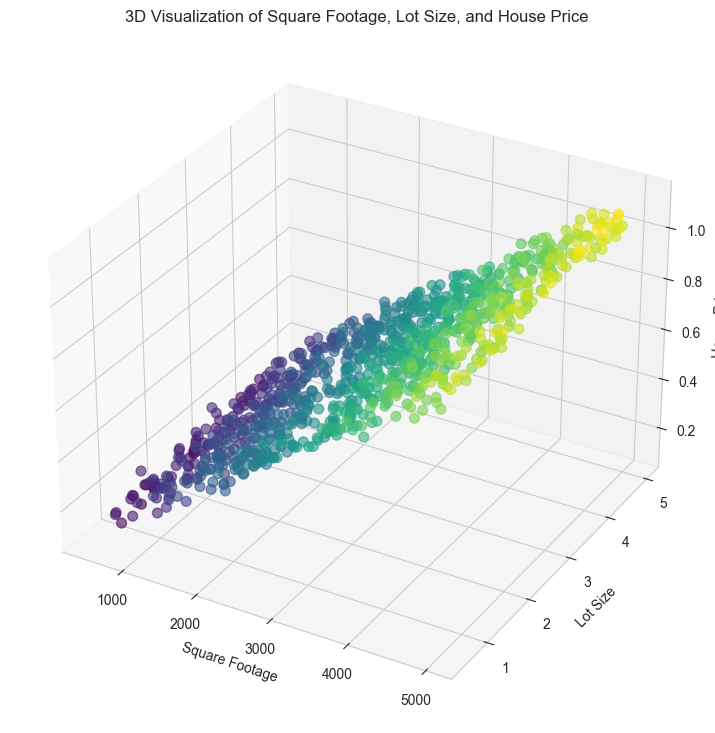

In [101]:

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

xs = df['Square_Footage']
ys = df['Lot_Size']
zs = df['House_Price']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, c=df['House_Price'], cmap='viridis')

ax.set_xlabel('Square Footage')
ax.set_ylabel('Lot Size')
ax.set_zlabel('House Price')
ax.set_title('3D Visualization of Square Footage, Lot Size, and House Price')
plt.show()

Conclusions:

    1.Larger homes (higher square footage) in high-quality neighborhoods command significantly higher prices.

    2.Interaction effects between square footage and neighborhood quality suggest that location amplifies the impact of home size on price.

    3.Some features (e.g., lot size) show non-linear relationships with house price, indicating potential for advanced modeling techniques like polynomial regression.